<a href="https://colab.research.google.com/github/kk221/AllWomenTech_Projects/blob/Foodie_lover/Foodie_lover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foodie lovers

![alt text](https://gifs.caractereconseil.com//gifs/O-Fanta_en_cuisine.gif?1541768017)

**Business case:** There will be a foodie fair in your city next summer (if coronavirus allows it to do), and the organsers have contacted us because they are interested in performing an analysis of the world wide cuisines. They manage to obtain a dataset from different cuisines all over the world, together with the list of the most common ingredients.

Some of our strongest geographic and cultural associations are tied to a region's local foods, so they are interested to know more information regarding them in order to organise the different stands. People from Marketing have ideas on how to plan the fair but they want to complement their ideas with some rough results.

In [ ]:
# tip: use foodie_dataset.json to perform a complete analysis of the different cuisines. It is a json file so:

# json.load(open(path))

# You should:
# - Preprocess the dataset by using also NLP techniques
# - Frequency distribution, ie with wordcloud 
# - Visualisation techniques
# etc

# Load Library

In [ ]:
! pip install -U spacy
import spacy 
import en_core_web_sm
! python -m spacy download es
import es_core_news_sm
from spacy import displacy
from collections import Counter
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load the data
! pip install pydrive                             # Package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth                    # Other necessary packages
from oauth2client.client import GoogleCredentials
auth.authenticate_user()                         # Follow prompt in the authorization process
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

In [ ]:
drive = GoogleDrive(gauth)
data = drive.CreateFile({'id': '1hbJKOLvboAowGqv5nexxGzqyIql_zxC1'})   # "your_module_file_id" is the part after "id=" in the shareable link 
data.GetContentFile('Ex 6.1. foodie_dataset.json')                        # Save the module file to Colab VM
# json : https://drive.google.com/open?id=1hbJKOLvboAowGqv5nexxGzqyIql_zxC1
# Add the name of the file
filename = 'Ex 6.1. foodie_dataset.json'

In [ ]:
import json

In [ ]:
# and load it
# json.load(open(filename))

# Load Dataset

In [ ]:
# Load JSON String into Pandas DataFrame

df = pd.read_json (filename)
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


# Preprocessing

In [ ]:
# dataset info, big database with 39774 rows 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [ ]:
# Italian cuisine has counted the most, brazilian the least
# cajun_creole - US French speaker

df['cuisine'].value_counts() 

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

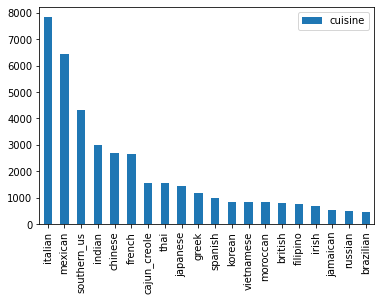

In [ ]:
# cuisine barplot

cuisine = df['cuisine'].value_counts() 
cuisine.plot.bar(stacked=True)
plt.legend()

plt.show()

In [ ]:
# iterate each ingredient in one cuisine - id 10259 greek cuisine 
pd.Series(df['ingredients'][0]).value_counts() 

feta cheese crumbles    1
seasoning               1
garbanzo beans          1
grape tomatoes          1
romaine lettuce         1
black olives            1
garlic                  1
purple onion            1
pepper                  1
dtype: int64

In [ ]:
# another way to see
print('\n'.join(df['ingredients'][0])) 

romaine lettuce
black olives
grape tomatoes
garlic
pepper
purple onion
seasoning
garbanzo beans
feta cheese crumbles


In [ ]:
# Iriterate each ingredients in each cuisine 

#i = 0 
#for i in range(len(df['ingredients'])):
  #if i < len(df['ingredients']):
    #ing = pd.Series(df['ingredients'][i]).value_counts()  
  #i = i+1
  #print(ing)

Streaming output truncated to the last 5000 lines.
shredded mozzarella cheese    1
bay leaves                    1
tomato paste                  1
ricotta cheese                1
fresh basil                   1
hamburger                     1
fresh parsley                 1
dtype: int64
dry yeast          1
nonfat dry milk    1
sponge             1
cornmeal           1
warm water         1
salt               1
bread flour        1
dtype: int64
fresh lemon juice         1
ground coriander          1
cinnamon sticks           1
extra-virgin olive oil    1
ground cloves             1
sweet paprika             1
flat leaf parsley         1
lamb shoulder             1
ground black pepper       1
cilantro leaves           1
water                     1
carrots                   1
pitted green olives       1
garlic cloves             1
cayenne pepper            1
saffron threads           1
onions                    1
lemon zest                1
ground ginger             1
ground cumin        

In [ ]:
# convert list to string

df['list_str'] = df['ingredients'].apply(lambda x: ','.join(map(str, x)))


In [ ]:
# No need to remove stopwords here

def clean_text(text):
    # lowercase
    text = str(text).lower()
    # remove whitespace head and tail
    text = text.strip()
    # remove text in square brackets
    #text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove punctuation
    text = re.sub('<.*?>+', '', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #text = re.sub('\s', '', text) - remove all space
    # remove numbers
    text = re.sub('\n', '', text) 
    #text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
# clean_text for ingredinets by using lambda

df['clean_ing'] = df['list_str'].map(lambda x: clean_text(x))


In [ ]:
df.head()

,id,cuisine,ingredients,list_str,clean_ing
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga...","romaine lettuce,black olives,grape tomatoes,ga..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground...","plain flour,ground pepper,salt,tomatoes,ground..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c...","eggs,pepper,salt,mayonaise,cooking oil,green c..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt","water,vegetable oil,wheat,salt"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper...","black pepper,shallots,cornflour,cayenne pepper..."


In [ ]:
# drop id column

df.drop('id',axis =1,inplace=True)

In [ ]:
# Top words 

vocab = Counter()
for ing in df["clean_ing"]:
    for word in ing.split(' '):
        vocab[word] += 1

vocab.most_common(20)

[('black', 6837),
 ('chicken', 5762),
 ('olive', 4146),
 ('bell', 3912),
 ('fresh', 3617),
 ('red', 3546),
 ('pepper', 3188),
 ('ground', 3161),
 ('white', 2756),
 ('parmesan', 2332),
 ('soy', 2331),
 ('lemon', 2312),
 ('sodium', 2207),
 ('skinless', 2147),
 ('green', 1979),
 ('cilantro', 1916),
 ('oil', 1888),
 ('lime', 1879),
 ('cheese', 1603),
 ('cheddar', 1507)]

In [ ]:
print(type(vocab.most_common(20)))

<class 'list'>


In [ ]:
#  most common barplot

In [ ]:
most_com = pd.DataFrame(vocab.most_common(20),columns =['ing','val']) 
df['ing'] = df.index
#most_com.head()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

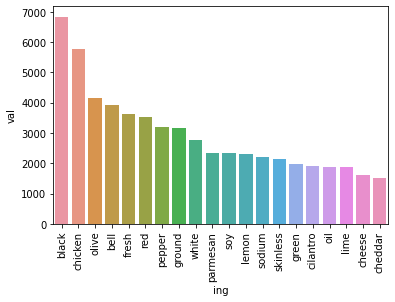

In [ ]:
ax = sns.barplot(x="ing", y="val", data=most_com)
plt.xticks(rotation = 90)

## NLTK

### Tokenize

In [ ]:
# split each text into tokens 

def tokenize(text):
    # regx: Matches any character that is not a word character (alphanumeric & underscore). Equivalent to [^A-Za-z0-9_]
    tokens=re.split('\W+',text)
    return tokens

In [ ]:
nltk.download('punkt')
df['token_ing']=df["clean_ing"].apply(lambda row : tokenize(row.lower()))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df.head()

,cuisine,ingredients,list_str,clean_ing,ing,token_ing
0,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga...","romaine lettuce,black olives,grape tomatoes,ga...",0,"[romaine, lettuce, black, olives, grape, tomat..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground...","plain flour,ground pepper,salt,tomatoes,ground...",1,"[plain, flour, ground, pepper, salt, tomatoes,..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c...","eggs,pepper,salt,mayonaise,cooking oil,green c...",2,"[eggs, pepper, salt, mayonaise, cooking, oil, ..."
3,indian,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt","water,vegetable oil,wheat,salt",3,"[water, vegetable, oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper...","black pepper,shallots,cornflour,cayenne pepper...",4,"[black, pepper, shallots, cornflour, cayenne, ..."


In [ ]:
# remove stopwords

nltk.download('stopwords')
from nltk.corpus import stopwords

# stopwords - new list
stopwords = ['red','orange','yellow','green','blue','purple','brown', 'magenta', 'tan','cyan','olive','maroon','navy','aquamarine',
'turquoise','silver','teal','indigo','violet','pink','black','white','gray']
#stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# apply no stopwords to new column

def remove_stopwords(text):
    clean_text=[word for word in text if word not in stopwords]
    return clean_text 

In [ ]:
# add new column no stopwords

df['clean_text'] = df['token_ing'].apply(lambda row :remove_stopwords(row) )

In [ ]:
print(type(df['clean_text'][0]))

<class 'list'>


In [ ]:
df.head()

,cuisine,ingredients,list_str,clean_ing,token_ing,clean_text
0,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga...","romaine lettuce,black olives,grape tomatoes,ga...","[romaine, lettuce, black, olives, grape, tomat...","[romaine, lettuce, olives, grape, tomatoes, ga..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground...","plain flour,ground pepper,salt,tomatoes,ground...","[plain, flour, ground, pepper, salt, tomatoes,...","[plain, flour, ground, pepper, salt, tomatoes,..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c...","eggs,pepper,salt,mayonaise,cooking oil,green c...","[eggs, pepper, salt, mayonaise, cooking, oil, ...","[eggs, pepper, salt, mayonaise, cooking, oil, ..."
3,indian,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt","water,vegetable oil,wheat,salt","[water, vegetable, oil, wheat, salt]","[water, vegetable, oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper...","black pepper,shallots,cornflour,cayenne pepper...","[black, pepper, shallots, cornflour, cayenne, ...","[pepper, shallots, cornflour, cayenne, pepper,..."


In [ ]:
# list - string

df['list_str3'] = df['clean_text'].apply(lambda x: ','.join(map(str, x)))


In [ ]:
print(type(df['list_str3'][0]))

<class 'str'>


In [ ]:
# lemmatizer

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def lemmatizing(tokenized_text):
    wn = nltk.WordNetLemmatizer()
    print(type(tokenized_text))
    tokens = [wn.lemmatize(word) for word in tokenized_text]
    print(tokens)
    return(tokens)

df['lemm'] = df['list_str3'].apply(lambda row :lemtz(row) )

## Word Cloud

In [ ]:
from wordcloud import WordCloud


In [ ]:
# convert list to string

df['list_str2'] = df['clean_text'].apply(lambda x: ','.join(map(str, x)))

In [ ]:
# Top words 

vocab = Counter()
for ing in df["list_str2"]:
    for word in ing.split(','):
        vocab[word] += 1

vocab.most_common(20)

[('pepper', 25742),
 ('salt', 24462),
 ('oil', 23344),
 ('garlic', 18941),
 ('ground', 18271),
 ('fresh', 17853),
 ('sauce', 13129),
 ('sugar', 12493),
 ('onions', 12341),
 ('cheese', 11776),
 ('chicken', 11471),
 ('water', 9790),
 ('flour', 8851),
 ('butter', 8648),
 ('tomatoes', 8599),
 ('powder', 8290),
 ('chopped', 7884),
 ('cloves', 7557),
 ('juice', 7146),
 ('onion', 6901)]

In [ ]:
print(type(vocab.most_common(20)))

<class 'list'>


In [ ]:
# list to string

com_ing = pd.Series(vocab.most_common(20)).apply(lambda x: ','.join(map(str, x)))

In [ ]:
print(type(com_ing))

<class 'pandas.core.series.Series'>


In [ ]:
df.head()

,cuisine,ingredients,list_str,clean_ing,ing,token_ing,clean_text,list_str2
0,greek,"[romaine lettuce, black olives, grape tomatoes...","romaine lettuce,black olives,grape tomatoes,ga...","romaine lettuce,black olives,grape tomatoes,ga...",0,"[romaine, lettuce, black, olives, grape, tomat...","[romaine, lettuce, olives, grape, tomatoes, ga...","romaine,lettuce,olives,grape,tomatoes,garlic,p..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","plain flour,ground pepper,salt,tomatoes,ground...","plain flour,ground pepper,salt,tomatoes,ground...",1,"[plain, flour, ground, pepper, salt, tomatoes,...","[plain, flour, ground, pepper, salt, tomatoes,...","plain,flour,ground,pepper,salt,tomatoes,ground..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","eggs,pepper,salt,mayonaise,cooking oil,green c...","eggs,pepper,salt,mayonaise,cooking oil,green c...",2,"[eggs, pepper, salt, mayonaise, cooking, oil, ...","[eggs, pepper, salt, mayonaise, cooking, oil, ...","eggs,pepper,salt,mayonaise,cooking,oil,chilies..."
3,indian,"[water, vegetable oil, wheat, salt]","water,vegetable oil,wheat,salt","water,vegetable oil,wheat,salt",3,"[water, vegetable, oil, wheat, salt]","[water, vegetable, oil, wheat, salt]","water,vegetable,oil,wheat,salt"
4,indian,"[black pepper, shallots, cornflour, cayenne pe...","black pepper,shallots,cornflour,cayenne pepper...","black pepper,shallots,cornflour,cayenne pepper...",4,"[black, pepper, shallots, cornflour, cayenne, ...","[pepper, shallots, cornflour, cayenne, pepper,...","pepper,shallots,cornflour,cayenne,pepper,onion..."


In [ ]:
# generate word cloud with frequency 

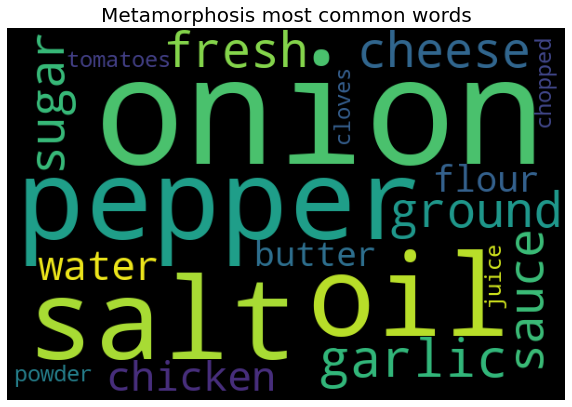

In [ ]:
# Generate a word cloud image

text = " ".join(x for x in com_ing)

wordcloud = WordCloud(background_color='black',width=600,height=400).generate(text)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title("Metamorphosis most common words", fontsize=20);


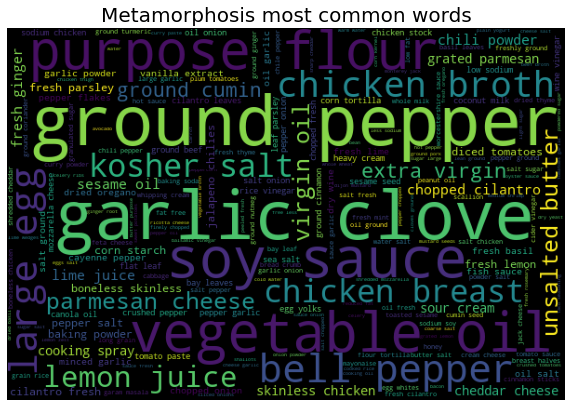

In [ ]:
text = " ".join(x for x in df.list_str2)

# Generate a word cloud image
wordcloud = WordCloud(background_color='black',width=600,height=400).generate(text)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title("ingredients widely used", fontsize=20);

- Salt is the most used species in all cuisine

- chicken is the most used meat for all cuisine

- there are many different ways to deal with pepper: ground, bell ...

## WC for each cuisine 

In [ ]:
from PIL import Image
import os
from os import path

### Italy

- Italians love parmesan cheese
- Italians love to use species: garlic clove, ground pepper, fresh basil, onion
- chicken is the most used meat ingredient

In [ ]:
# word cloud with frequency

# Top words 

vocab_it = Counter()
for ing in df[df['cuisine']=='italian']['list_str2']:
    for word in ing.split(','):
        vocab_it[word] += 1

vocab_it.most_common(20)

[('cheese', 5883),
 ('pepper', 5524),
 ('oil', 5191),
 ('salt', 4883),
 ('fresh', 4589),
 ('garlic', 4177),
 ('ground', 2983),
 ('tomatoes', 2473),
 ('parmesan', 2456),
 ('grated', 2069),
 ('basil', 2005),
 ('cloves', 1942),
 ('dried', 1833),
 ('chicken', 1828),
 ('parsley', 1746),
 ('butter', 1672),
 ('wine', 1521),
 ('chopped', 1514),
 ('onions', 1489),
 ('water', 1483)]

In [ ]:
# list to string

com_ing_it = pd.Series(vocab_it.most_common(20)).apply(lambda x: ','.join(map(str, x)))

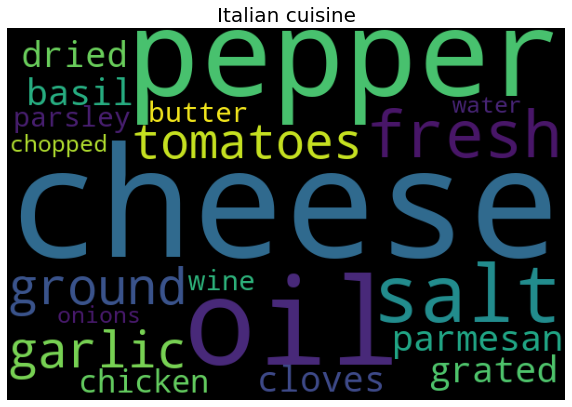

In [ ]:
# Generate a word cloud image

it = " ".join(x for x in com_ing_it)

wordcloud = WordCloud(background_color='black',width=600,height=400).generate(it)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title("Italian cuisine", fontsize=20);

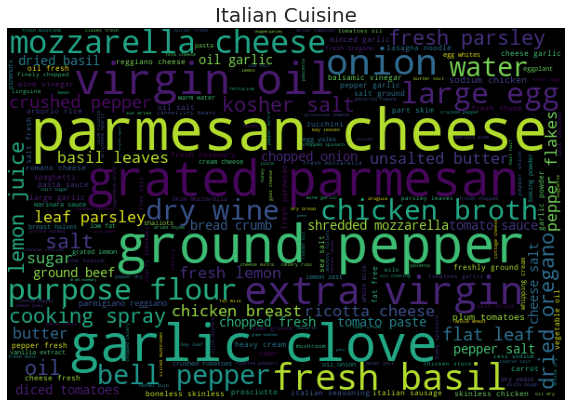

In [ ]:
it = " ".join(ings for ings in df[df['cuisine']=='italian']['list_str2'])
wordcloud_it = WordCloud(background_color='black',width=600,height=400).generate(it)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud_it)
ax.axis('off')
ax.set_title("Italian Cuisine", fontsize=20);

### Mexico 

- Mexicans love onions 
- Mexicans also love to use species: ground cumin, chopped cilantro, chili powder
- Mexicans prefer sour taste: lime juice and sour cream

In [ ]:
# word cloud with frequency

# Top words 

vocab_mx = Counter()
for ing in df[df['cuisine']=='mexican']['list_str2']:
    for word in ing.split(','):
        vocab_mx[word] += 1

vocab_mx.most_common(20)

[('pepper', 4355),
 ('salt', 3935),
 ('ground', 3495),
 ('garlic', 3224),
 ('cheese', 2994),
 ('oil', 2978),
 ('cilantro', 2794),
 ('fresh', 2597),
 ('chicken', 2463),
 ('onions', 2370),
 ('powder', 2352),
 ('tomatoes', 2342),
 ('lime', 2289),
 ('corn', 2235),
 ('tortillas', 2137),
 ('onion', 2066),
 ('cumin', 2061),
 ('chopped', 2054),
 ('cream', 1909),
 ('beans', 1706)]

In [ ]:
# list to string

com_ing_mx = pd.Series(vocab_mx.most_common(20)).apply(lambda x: ','.join(map(str, x)))

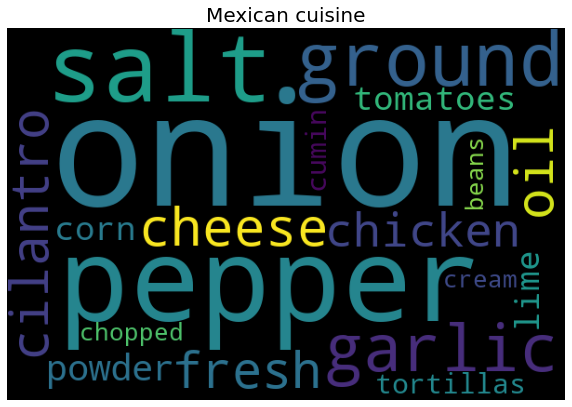

In [ ]:
# Generate a word cloud image

mx = " ".join(x for x in com_ing_mx)

wordcloud = WordCloud(background_color='black',width=600,height=400).generate(mx)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title("Mexican cuisine", fontsize=20);

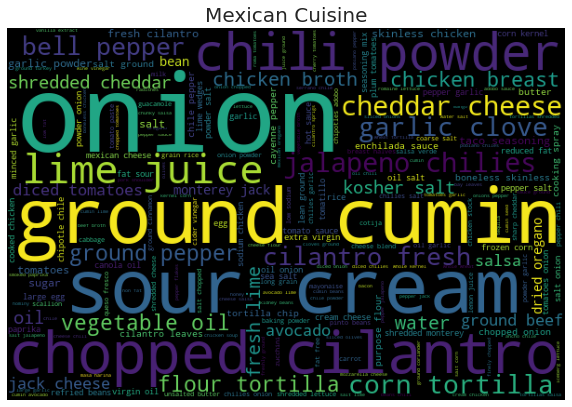

In [ ]:
mx = " ".join(ings for ings in df[df['cuisine']=='mexican']['list_str2'])
wordcloud_mx = WordCloud(background_color='black',width=600,height=400).generate(mx)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud_mx)
ax.axis('off')
ax.set_title("Mexican Cuisine", fontsize=20);

### South US vs French US

- Both are using pepper but south us cuisine is using ground pepper, while in cajun cuisine, there are more options of pepper besides ground pepper, they also have bell pepper and cayenne pepper

- In south us, the cuisine is more about baking due to baking powder, baking soda,large egg, milk and vanilla extract

- Onion appears in both cuisine

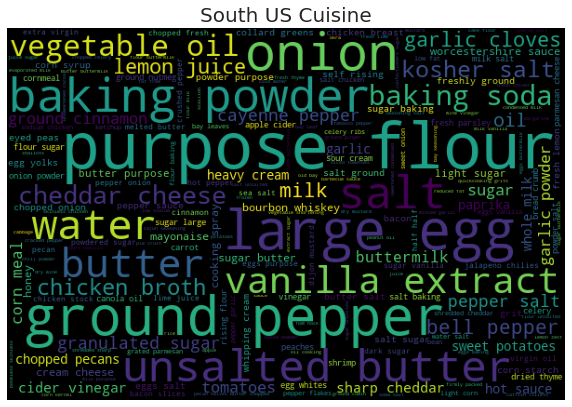

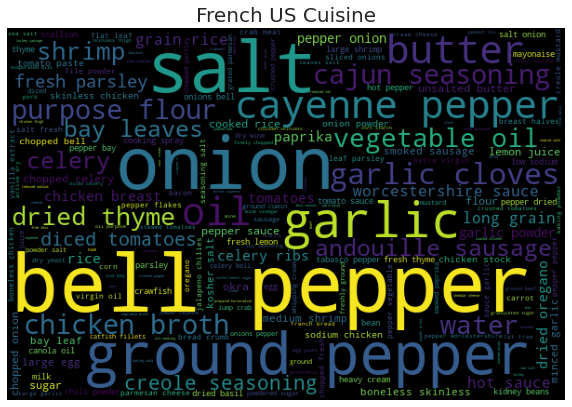

In [ ]:
from PIL import Image
import os
from os import path


s_us = " ".join(ings for ings in df[df['cuisine']=='southern_us']['list_str2'])
wordcloud_s_us = WordCloud(background_color='black',width=600,height=400).generate(s_us)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud_s_us)
ax.axis('off')
ax.set_title("South US Cuisine", fontsize=20);

f_us = " ".join(ings for ings in df[df['cuisine']=='cajun_creole']['list_str2'])
wordcloud_f_us = WordCloud(background_color='black',width=600,height=400).generate(f_us)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud_f_us)
ax.axis('off')
ax.set_title("French US Cuisine", fontsize=20);

#### Frequency 

In [ ]:
### frequency 

# word cloud with frequency

# Top words 

vocab_s_us = Counter()
for ing in df[df['cuisine']=='southern_us']['list_str2']:
    for word in ing.split(','):
        vocab_s_us[word] += 1

vocab_s_us.most_common(20)



[('salt', 3043),
 ('pepper', 2680),
 ('sugar', 2318),
 ('butter', 2155),
 ('flour', 1847),
 ('ground', 1542),
 ('eggs', 1386),
 ('powder', 1302),
 ('oil', 1277),
 ('all', 1264),
 ('purpose', 1264),
 ('baking', 1231),
 ('milk', 1119),
 ('garlic', 987),
 ('cream', 965),
 ('large', 934),
 ('cheese', 912),
 ('chicken', 909),
 ('water', 895),
 ('fresh', 875)]

In [ ]:
# list to string

com_ing_s_us = pd.Series(vocab_s_us.most_common(20)).apply(lambda x: ','.join(map(str, x)))

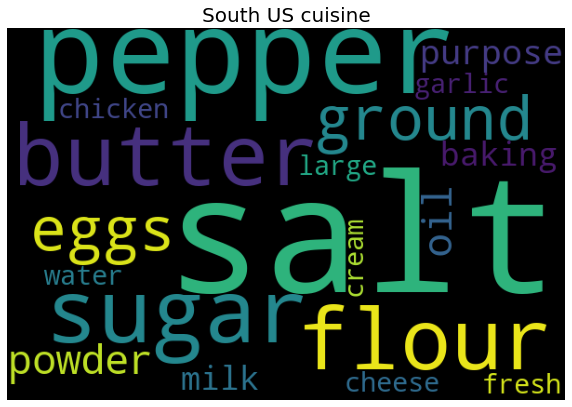

In [ ]:
# Generate a word cloud image

s_us = " ".join(x for x in com_ing_s_us)

wordcloud = WordCloud(background_color='black',width=600,height=400).generate(s_us)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title("South US cuisine", fontsize=20);

In [ ]:
vocab_f_us = Counter()
for ing in df[df['cuisine']=='cajun_creole']['list_str2']:
    for word in ing.split(','):
        vocab_f_us[word] += 1

vocab_f_us.most_common(20)

[('pepper', 2295),
 ('garlic', 1003),
 ('salt', 991),
 ('onions', 866),
 ('oil', 821),
 ('chicken', 740),
 ('bell', 696),
 ('ground', 680),
 ('sauce', 664),
 ('seasoning', 626),
 ('celery', 619),
 ('rice', 537),
 ('chopped', 532),
 ('dried', 522),
 ('fresh', 507),
 ('tomatoes', 505),
 ('butter', 499),
 ('shrimp', 482),
 ('flour', 450),
 ('onion', 448)]

In [ ]:
# list to string

com_ing_f_us = pd.Series(vocab_f_us.most_common(20)).apply(lambda x: ','.join(map(str, x)))

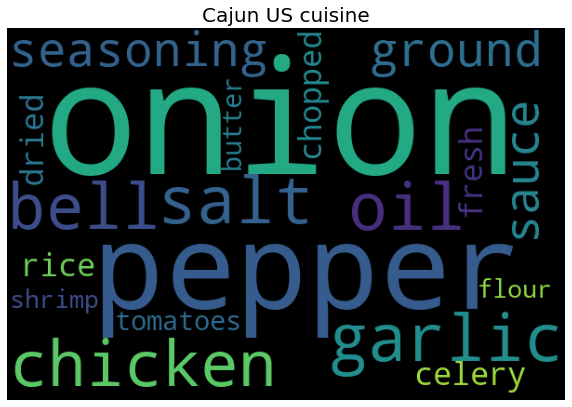

In [ ]:
# Generate a word cloud image

f_us = " ".join(x for x in com_ing_f_us)

wordcloud = WordCloud(background_color='black',width=600,height=400).generate(f_us)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title("Cajun US cuisine", fontsize=20);

### China vs Japan

- Soy sauce, onion, sesame oil, ginger are the most used for asian food, both for Chinese cuisine and japanese cuisine， sugar is one of the seasonings for both as well

- In Japanese cuisine, rice vinegar stands out probably due to sushi

- In Chinese cuisine, corn starch stands out probably because it's a way to soften the meat and thickening the soup before serving 

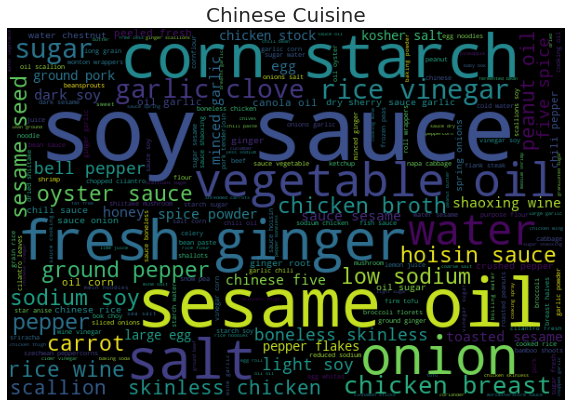

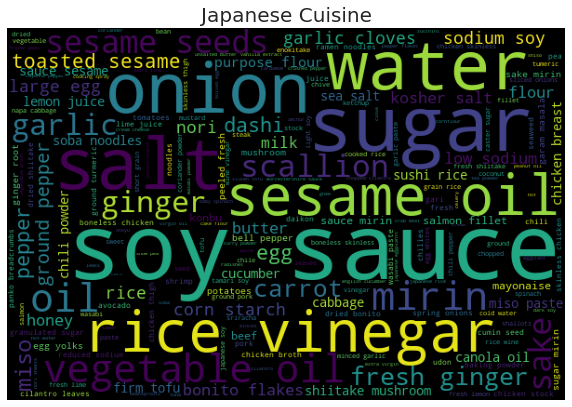

In [ ]:


cn = " ".join(ings for ings in df[df['cuisine']=='chinese']['list_str2'])
wordcloud_cn = WordCloud(background_color='black',width=600,height=400).generate(cn)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud_cn)
ax.axis('off')
ax.set_title("Chinese Cuisine", fontsize=20);

jp = " ".join(ings for ings in df[df['cuisine']=='japanese']['list_str2'])
wordcloud_jp = WordCloud(background_color='black',width=600,height=400).generate(jp)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud_jp)
ax.axis('off')
ax.set_title("Japanese Cuisine", fontsize=20);

#### Frequency 

In [ ]:
### frequency 

# word cloud with frequency

# Top words 

vocab_cn = Counter()
for ing in df[df['cuisine']=='chinese']['list_str2']:
    for word in ing.split(','):
        vocab_cn[word] += 1

vocab_cn.most_common(20)



[('sauce', 3432),
 ('oil', 3005),
 ('soy', 2244),
 ('garlic', 1692),
 ('pepper', 1575),
 ('sesame', 1488),
 ('ginger', 1483),
 ('sugar', 1419),
 ('chicken', 1331),
 ('rice', 1249),
 ('salt', 1224),
 ('onions', 1142),
 ('water', 1129),
 ('fresh', 1023),
 ('corn', 1005),
 ('starch', 952),
 ('vinegar', 870),
 ('ground', 788),
 ('wine', 693),
 ('vegetable', 665)]

In [ ]:
# list to string

com_ing_cn = pd.Series(vocab_cn.most_common(20)).apply(lambda x: ','.join(map(str, x)))

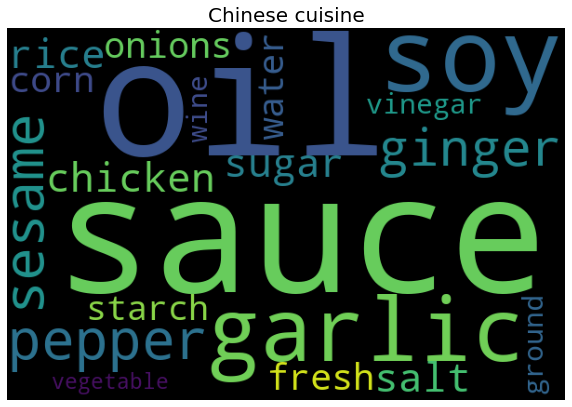

In [ ]:
# Generate a word cloud image

cn = " ".join(x for x in com_ing_cn)

wordcloud = WordCloud(background_color='black',width=600,height=400).generate(cn)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title("Chinese cuisine", fontsize=20);

In [ ]:
vocab_jp = Counter()
for ing in df[df['cuisine']=='japanese']['list_str2']:
    for word in ing.split(','):
        vocab_jp[word] += 1

vocab_jp.most_common(20)

[('sauce', 930),
 ('oil', 901),
 ('soy', 779),
 ('sugar', 649),
 ('salt', 579),
 ('rice', 554),
 ('sesame', 520),
 ('water', 479),
 ('ginger', 461),
 ('mirin', 402),
 ('onions', 397),
 ('fresh', 388),
 ('pepper', 363),
 ('garlic', 358),
 ('vinegar', 337),
 ('seeds', 306),
 ('sake', 289),
 ('vegetable', 279),
 ('chicken', 274),
 ('ground', 261)]

In [ ]:
# list to string

com_ing_jp = pd.Series(vocab_jp.most_common(20)).apply(lambda x: ','.join(map(str, x)))

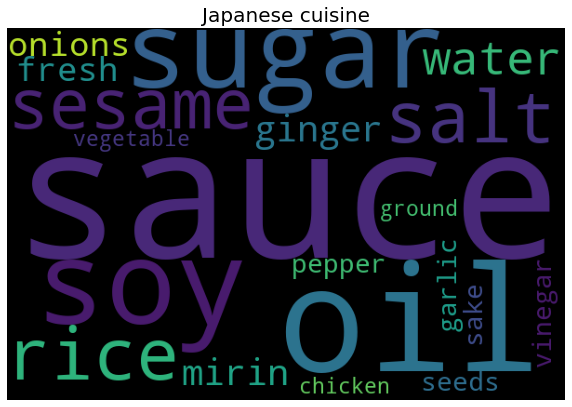

In [ ]:
# Generate a word cloud image

jp = " ".join(x for x in com_ing_jp)

wordcloud = WordCloud(background_color='black',width=600,height=400).generate(jp)

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(figsize = (10, 8))
ax.imshow(wordcloud)
ax.axis('off')
ax.set_title("Japanese cuisine", fontsize=20);